# European Football Odds Analysis
> Checking out Soccer/Football odds

- toc: false
- badges: true
- comments: true
- categories: [soccer, benchmark, webscraping, brier, accuracy, calibration]

I've started thinking about applying machine learning to betting the European Soccer Leagues. It seems like it's going to be a different problem than my [previous work on baseball](https://rdpharr.github.io/project_notes/baseball/benchmark/webscraping/brier/accuracy/calibration/2020/09/20/baseball_project.html), as there are 3 possible outcomes for every match (win, lose, draw). But still, I'd like to see if the profitable machine learning process I put together will hold.  

The first step in this process is getting data on how well the oddsmakers can predict the outcomes of these matches. This establishes the goals any model I make will need to exceed to be successful. [Football-data.co.uk](https://www.football-data.co.uk) is a great site that publishes historical odds from different matchmakers in easy-to-use csv format. So let's pull down their spreadsheets and see how they did.

**Each blog post on this site, including this one, is executable. Use the buttons at the top to run the code on Binder of Colab and get fresh results for yourself.** You can also download it from Github to run the notebook locally.

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
csvs = [
    'https://www.football-data.co.uk/mmz4281/2021/SP1.csv',
    'https://www.football-data.co.uk/mmz4281/1920/SP1.csv',
    'https://www.football-data.co.uk/mmz4281/1819/SP1.csv',
    'https://www.football-data.co.uk/mmz4281/1718/SP1.csv',
    'https://www.football-data.co.uk/mmz4281/2021/E0.csv',
    'https://www.football-data.co.uk/mmz4281/1920/E0.csv',
    'https://www.football-data.co.uk/mmz4281/1819/E0.csv',
    'https://www.football-data.co.uk/mmz4281/1718/E0.csv',
    'https://www.football-data.co.uk/mmz4281/2021/D1.csv',
    'https://www.football-data.co.uk/mmz4281/1920/D1.csv',
    'https://www.football-data.co.uk/mmz4281/1819/D1.csv',
    'https://www.football-data.co.uk/mmz4281/1718/D1.csv',
    'https://www.football-data.co.uk/mmz4281/2021/I1.csv',
    'https://www.football-data.co.uk/mmz4281/1920/I1.csv',
    'https://www.football-data.co.uk/mmz4281/1819/I1.csv',
    'https://www.football-data.co.uk/mmz4281/1718/I1.csv',
    'https://www.football-data.co.uk/mmz4281/2021/F1.csv',
    'https://www.football-data.co.uk/mmz4281/1920/F1.csv',
    'https://www.football-data.co.uk/mmz4281/1819/F1.csv',
    'https://www.football-data.co.uk/mmz4281/1718/F1.csv',
]
df = pd.DataFrame()
for c in csvs:
    df = pd.concat([df, pd.read_csv(c)])
df.shape

(6083, 127)

Over 6000 matches should be enough, right? These spredsheets are pretty dense, with 127 columns of information. See their [notes](https://www.football-data.co.uk/notes.txt) for how to decode the column headers.

Let's see the %ages for home, away and draw results using the 'FTR' (Full Time Result) column

In [3]:
# game outcomes
df['FTR'].value_counts()/len(df)

H    0.438106
A    0.310044
D    0.251849
Name: FTR, dtype: float64

The home team seems to have a 12% advantage over the away team and 25% of matches end in a draw. This has always been pretty frustrating for me as a fan, I hate it when matches end in a draw. Even more when they are scoreless.

In [4]:
# scoreless games
df['total_score'] = df[['FTAG','FTHG']].sum(axis=1)
(df['total_score']==0).mean()

0.06822291632418215

OK, that only happens 6.8 percent of the time, but it still feels like a lot to me.

Back to the task at hand - how well do the oddsmakers predict the outcomes of the matches? First we need to find oddsmakers that are consistent throughout our dataset. The averages provided cover less than half of the matches.

In [5]:
df[['AvgH','AvgD','AvgA']].isna().sum()

AvgH    3652
AvgD    3652
AvgA    3652
dtype: int64

It looks like most of the columns with the match betting odds are mostly 3 letters long, so we'll use that as as shortcut to compare them

In [6]:
df[[x for x in df.columns if len(x)==3]].isna().sum().sort_values(ascending=True)[:25]

Div       0
FTR       0
HTR       1
HST       1
AST       1
BWH       2
BWD       2
BWA       2
WHH       3
VCH       3
VCD       3
IWH       3
IWA       3
IWD       3
WHD       3
VCA       3
WHA       3
PSH      12
PSD      12
PSA      12
AHh    3653
LBD    4259
LBH    4259
LBA    4259
dtype: int64

It looks like Bet&Win has the most match coverage. So let's look at them.

In [7]:
df.dropna(subset=['BWH','BWD','BWA'], inplace=True)
df.shape

(6081, 128)

In [8]:
df['favorite'] = df[['BWH','BWD','BWA']].idxmin(axis=1)
(df['favorite'].str[-1]==df['FTR']).mean()

0.5331359973688538

53% of the time, the odds favorite wins the match. This is much better than chance (33%).

## Calibration
Next, let's look at calibration. The odds for a match can be converted into a probability of each team winning. There's a great article on how to do this on [bettingexpert.com](https://www.bettingexpert.com/academy/advanced-betting-theory/odds-conversion-to-percentage). For this dataset, we are lucky to have dollar odds, so the probabilities are just the inverse of the odds. If the dollar odds are 2.5, then the probability is 1 / 2.5 = 40%.

Below we check whether those probabilities are accurate. When they say the home club has 40% odds, do they win 40% of the time? there are 2 good ways of knowing this: graphically with a reliability curve, and quantitatively, with a metric called Brier score. Both are below.

Home Win	 Brier Loss: 0.2098
Away Win	 Brier Loss: 0.1806
Draw		 Brier Loss: 0.1848


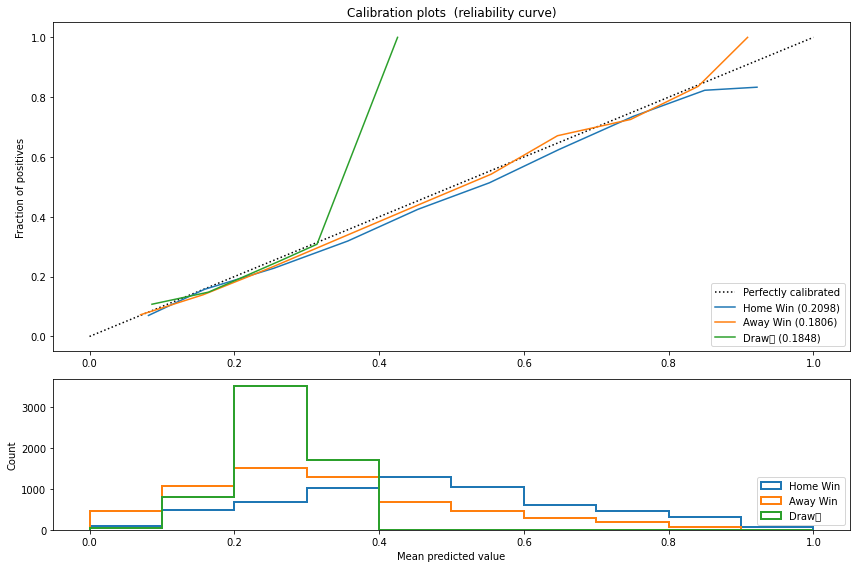

In [9]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

def cal_curve(data, bins):
    # adapted from:
    #https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    fig = plt.figure(1, figsize=(12, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for y_test, y_proba, name in data:
        brier = brier_score_loss(y_test, y_proba)
        print("{}\t Brier Loss: {:.4f}".format(
            name, brier))
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_proba, n_bins=bins)
        ax1.plot(mean_predicted_value, fraction_of_positives,
                 label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

data = [
    # truth, probabilities, labels
    (df['FTR']=='H', 1/df['BWH'], 'Home Win'),
    (df['FTR']=='A', 1/df['BWA'], 'Away Win'),
    (df['FTR']=='D', 1/df['BWD'], 'Draw\t'),
]
cal_curve(data, 10)

Except for the aberration in draws at 40%, that's really tight. The MLB baseball project had [0.2358 Brier Score](https://rdpharr.github.io/project_notes/baseball/benchmark/webscraping/brier/accuracy/calibration/2020/09/20/baseball_project.html). Lower is better in brier land, so this is 10-20% better. 

MLB Baseball accuracy was about 10% beter than chance, this seems to be 20%.

## Conclusion
It looks like European soccer is significantly easier for the oddsmakers to predict than American baseball. I'm interested to see if this affects our ability to exceed the odds maker predictions.

This was only meant to give an idea of how well oddsmakers predict matches, but I already see some interesting features of the data. I'll leave you to explore further. I'd be especially interested in the profitability of predicting match draws, as well as any differences among the leagues - perhaps some are more competitive than others.

Remember - hit the buttons at the top to download and run this notebook yourself.